In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow.keras import layers,Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D,concatenate,BatchNormalization,Activation
import os
from sklearn.model_selection import train_test_split

2024-10-22 18:20:26.280634: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-22 18:20:26.407835: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-22 18:20:26.454401: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-22 18:20:26.469120: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-22 18:20:26.572812: I tensorflow/core/platform/cpu_feature_guar

(941, 1193, 3)


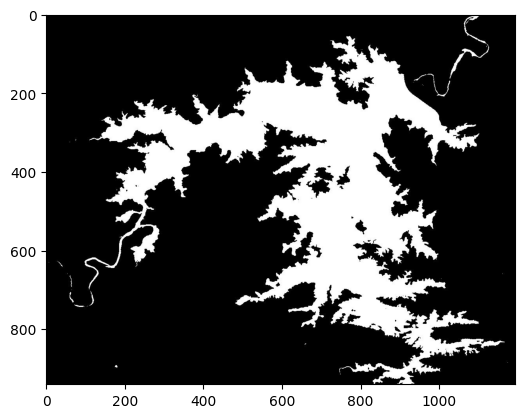

In [5]:
img=plt.imread("segmentation/Water Bodies Dataset/Masks/water_body_9.jpg")
plt.imshow(img)
print(img.shape)

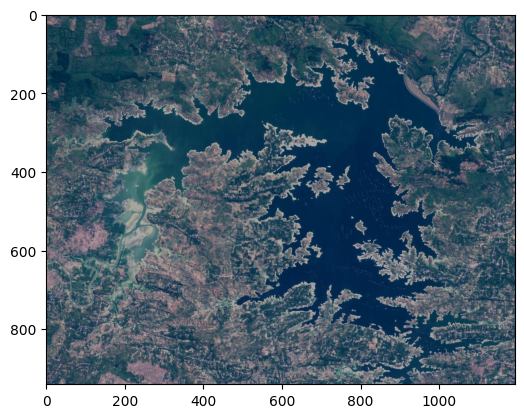

In [4]:
img=plt.imread("segmentation/Water Bodies Dataset/Images/water_body_9.jpg")
plt.imshow(img)

In [6]:
def load_imgs_images(dirpath,target):
    files=os.listdir(dirpath)
    for file in files:
        img_path=os.path.join(dirpath,file)
        img=cv2.imread(img_path)
        img=cv2.resize(img,(128,128))
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img=img/255.0
        target.append(img)
    print("Done")
def load_imgs_masks(dirpath,target):
    files=os.listdir(dirpath)
    for file in files:
        img_path=os.path.join(dirpath,file)
        img=cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
        img=cv2.resize(img,(128,128))
        img=np.expand_dims(img, axis=-1)
        #img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img=img/255.0
        target.append(img)
    print("Done")

In [7]:
images=[]
load_imgs_images("segmentation/Water Bodies Dataset/Images/",images)

Done


In [8]:
masks=[]
load_imgs_masks("segmentation/Water Bodies Dataset/Masks/",masks)

Done


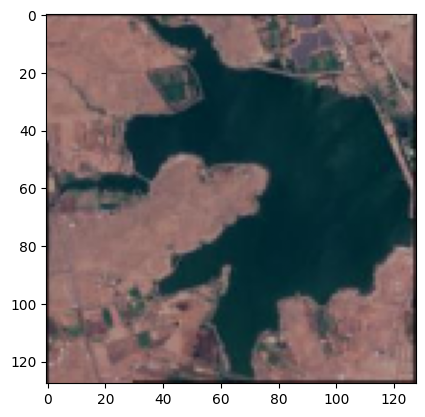

In [9]:
plt.imshow(images[0])

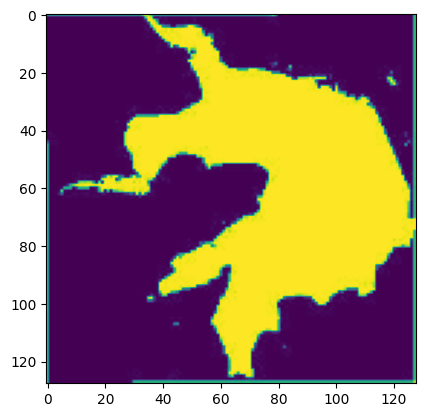

In [10]:
plt.imshow(masks[0])

In [11]:
x_train,x_test,y_train,y_test=train_test_split(np.array(images),np.array(masks),test_size=0.25,random_state=42)

In [31]:
from tensorflow.keras.applications import ConvNeXtTiny

def unet_convnext_model(input_size=(128, 128, 3)):
    # Load the ConvNeXt Tiny model as the backbone, excluding the top layers
    backbone = ConvNeXtTiny(include_top=False, input_shape=input_size)
    
    # Get the backbone's output (4x4 feature map)
    convnext_output = backbone.output
    
    # Decoder part (upsample the feature maps)
    
    # First upsampling: 4x4 -> 8x8
    u1 = layers.UpSampling2D(size=(2, 2))(convnext_output)
    u1 = layers.Conv2D(768, (3, 3), padding="same")(u1)
    u1 = layers.BatchNormalization()(u1)
    u1 = layers.ReLU()(u1)
    
    # Second upsampling: 8x8 -> 16x16
    u2 = layers.UpSampling2D(size=(2, 2))(u1)
    u2 = layers.Conv2D(384, (3, 3), padding="same")(u2)
    u2 = layers.BatchNormalization()(u2)
    u2 = layers.ReLU()(u2)
    
    # Third upsampling: 16x16 -> 32x32
    u3 = layers.UpSampling2D(size=(2, 2))(u2)
    u3 = layers.Conv2D(192, (3, 3), padding="same")(u3)
    u3 = layers.BatchNormalization()(u3)
    u3 = layers.ReLU()(u3)
    
    # Fourth upsampling: 32x32 -> 64x64
    u4 = layers.UpSampling2D(size=(2, 2))(u3)
    u4 = layers.Conv2D(96, (3, 3), padding="same")(u4)
    u4 = layers.BatchNormalization()(u4)
    u4 = layers.ReLU()(u4)
    
    # Fifth upsampling: 64x64 -> 128x128
    u5 = layers.UpSampling2D(size=(2, 2))(u4)
    u5 = layers.Conv2D(48, (3, 3), padding="same")(u5)
    u5 = layers.BatchNormalization()(u5)
    u5 = layers.ReLU()(u5)

    # Final output layer
    output = layers.Conv2D(1, (1, 1), activation="sigmoid")(u5)

    # Create the model
    model = Model(inputs=backbone.input, outputs=output)
    
    return model

# Instantiate the model
model = unet_convnext_model(input_size=(128, 128, 3))

In [35]:
model = unet_convnext_model(input_size=(128, 128, 3))

In [36]:
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

In [37]:
from keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)


history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    batch_size=8,
    callbacks=[early_stopping] )

Epoch 1/100


I0000 00:00:1729602156.457660   58975 service.cc:146] XLA service 0x72f9680042f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729602156.457696   58975 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
2024-10-22 18:32:37.041219: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-22 18:32:39.243374: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-22 18:32:41.619051: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 228 bytes spill stores, 228 bytes spill loads

2024-10-22 18:32:41.781527: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memo

266/267 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.5667 - loss: 0.6076

2024-10-22 18:33:40.298390: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 120 bytes spill stores, 120 bytes spill loads

2024-10-22 18:33:42.635294: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_36', 8 bytes spill stores, 8 bytes spill loads

2024-10-22 18:33:43.706502: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12', 244 bytes spill stores, 244 bytes spill loads

2024-10-22 18:33:44.145676: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_42', 228 bytes spill stores, 228 bytes spill loads

2024-10-22 18:33:45.096999: I external/local_xla/xla/stream_executo

267/267 ━━━━━━━━━━━━━━━━━━━━ 112s 241ms/step - accuracy: 0.5667 - loss: 0.6075 - val_accuracy: 0.5723 - val_loss: 0.5927
Epoch 2/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 31s 116ms/step - accuracy: 0.5756 - loss: 0.5908 - val_accuracy: 0.5865 - val_loss: 0.5813
Epoch 3/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 31s 117ms/step - accuracy: 0.5813 - loss: 0.5899 - val_accuracy: 0.5723 - val_loss: 0.5900
Epoch 4/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 32s 119ms/step - accuracy: 0.5764 - loss: 0.5910 - val_accuracy: 0.5896 - val_loss: 0.5787
Epoch 5/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 32s 120ms/step - accuracy: 0.5812 - loss: 0.5877 - val_accuracy: 0.5820 - val_loss: 0.5826
Epoch 6/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 32s 121ms/step - accuracy: 0.5743 - loss: 0.5913 - val_accuracy: 0.5877 - val_loss: 0.5785
Epoch 7/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 32s 121ms/step - accuracy: 0.5759 - loss: 0.5864 - val_accuracy: 0.5864 - val_loss: 0.5796
Epoch 8/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 32s 121ms/step - accuracy: 0.5771 - loss: 0.59

In [40]:

model.save("convnext_encoder_segmentation.keras")

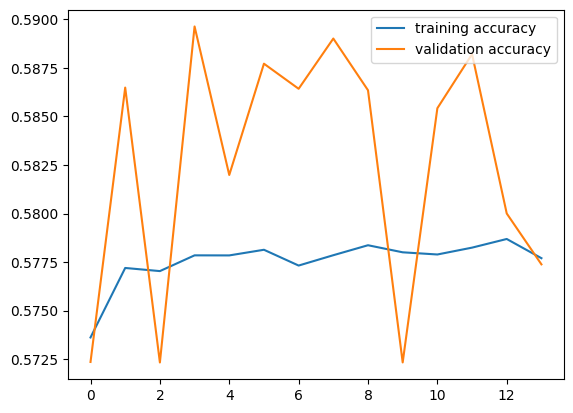

In [41]:
plt.plot(history.history["accuracy"],label="training accuracy")
plt.plot(history.history["val_accuracy"],label="validation accuracy")
plt.legend()
plt.show()

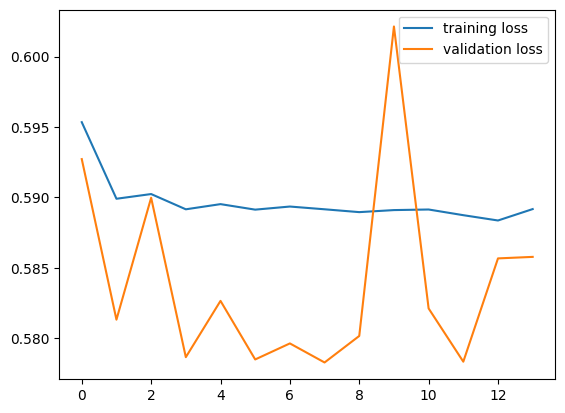

In [42]:
plt.plot(history.history["loss"],label="training loss")
plt.plot(history.history["val_loss"],label="validation loss")
plt.legend()
plt.show()